# Project Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

import dask
import dask.dataframe as dd
from dask import distributed
from distributed import Client

import matplotlib.pyplot as plt
import seaborn as sns

# from scipy.fftpack import fft, fftfreq # depending on scipy version
from scipy.fft import fft, fftfreq # depending on scipy version
from scipy.signal import find_peaks
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

c:\Users\jimmy\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper Functions

In [2]:
def week_of_year(date):
    formatted_date = dt.strptime(date, '%Y-%m-%d')
    return int(formatted_date.strftime("%W"))

def week_of_month(date):
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    formatted_date = dt.strptime(date, '%Y-%m-%d')
    first_of_month = dt.strptime(f'{year}-{month}-01', '%Y-%m-%d')
    date_week = int(formatted_date.strftime("%W"))
    month_start_week = int(first_of_month.strftime("%W"))
    return date_week - month_start_week

def plot_aggregated(frame, adtl_points=None, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    frame.index = pd.DatetimeIndex(frame.date, freq='D')
    plt.plot(frame.index.values.astype('M8[D]'), frame.sales.values)
    plt.scatter(frame.index.values.astype('M8[D]')[adtl_points], frame.sales[adtl_points], color='r')
    plt.show()

def create_aggregated_sales(frame, groupby_vars, agg_dict):
    if 'sales' not in agg_dict.keys():
        raise ValueError('sales must be in agg_dict')
    data = frame.groupby(groupby_vars, as_index=False).agg(agg_dict)
    if 'date' in agg_dict.keys():
        data.sort_values(by='date', inplace=True)
    return data

# Data Prep

In [3]:
# read the data files
df1 = pd.read_parquet('../data/m5_competition/sales_train_evaluation.parquet', engine='pyarrow')
df2 = pd.read_csv('../data/m5_competition/calendar.csv')

# add time features
df2['week_of_year'] = df2['date'].map(week_of_year)
df2['week_of_month'] = df2['date'].map(week_of_month)
df2['day_of_month'] = df2['date'].map(lambda x: int(x.split('-')[2]))

# transform data to long format
time_columns = df1.columns[6:]
df_long = pd.melt(
    df1,
    value_vars=time_columns,
    var_name='d',
    value_name='sales',
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
)

In [4]:
# merge with calendar dataset to add time features
df_train = pd.merge(df_long, df2, on='d')

# set dates variable for easy reference
dates = df2.date.astype('M8[D]').unique()[: df1.shape[1] - 6]

# Explore Data for Single Item

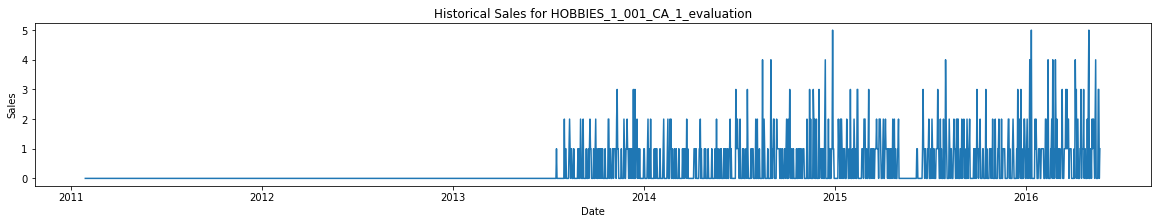

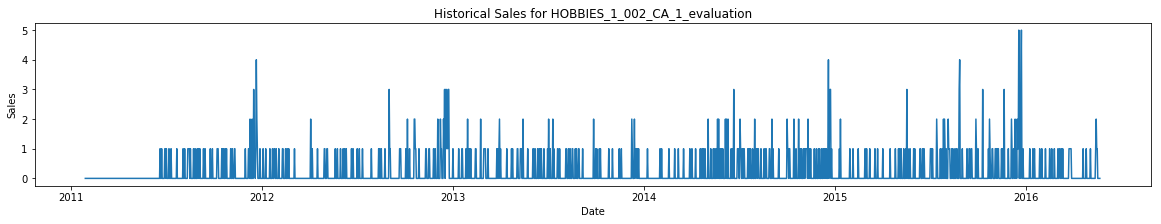

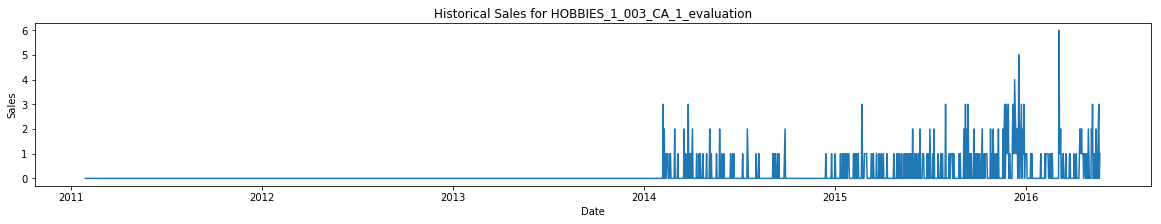

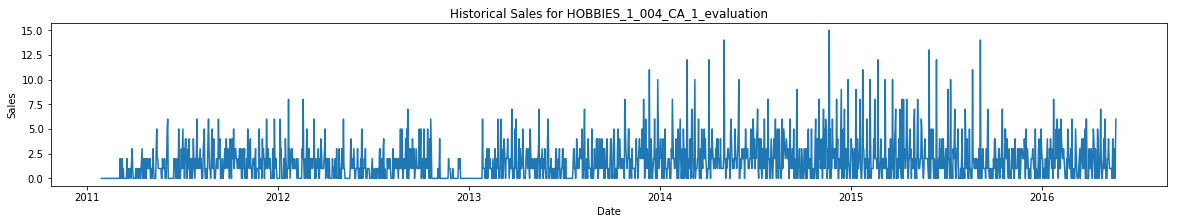

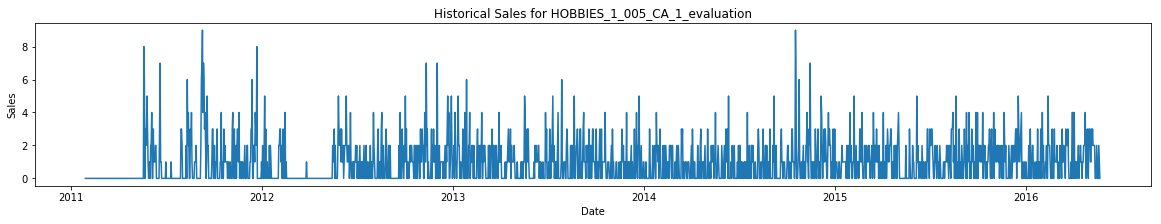

In [5]:
for i in range(5):
    id = df1.id.unique()[i]
    plt.figure(figsize=(20, 3))
    plt.plot(dates, df1.iloc[i, 6:].values)
    plt.title(f'Historical Sales for {id}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Create and Plot Aggregated Sales and Special Events

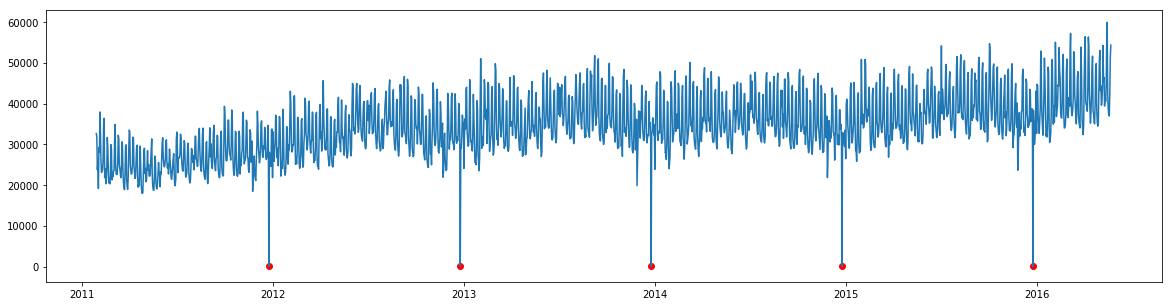

In [6]:
agg_dict = {
    'sales': 'sum',
    'date': 'first',
    'weekday': 'first',
    'wday': 'first',
    'day_of_month': 'first',
    'week_of_month': 'first',
    'week_of_year': 'first',
    'month': 'first',
    'year': 'first'
}

special_days = np.array([330, 696, 1061, 1426, 1791])
df_aggregated = create_aggregated_sales(df_train, 'd', agg_dict)
plot_aggregated(df_aggregated, special_days)

# Explore Periodicity with Fourier Transform

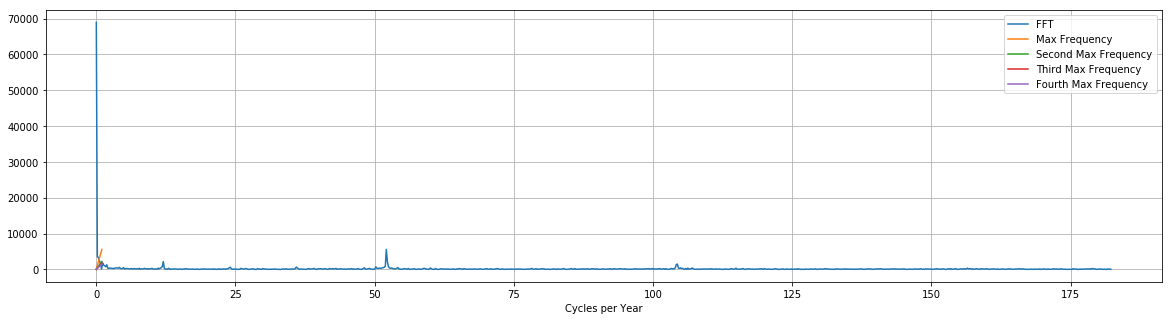

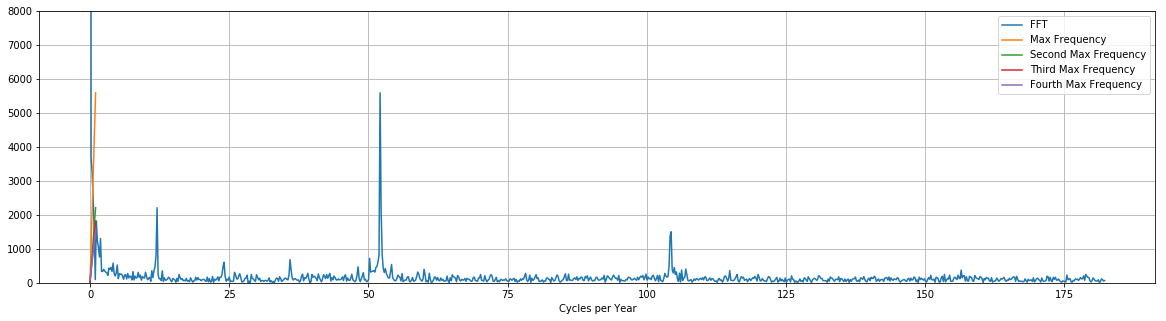

Max fequency component: 7.01 days per cycle
Second Max fequency component: 30.33 days per cycle
Third Max fequency component: 323.5 days per cycle
Fourth Max fequency component: 3.5 days per cycle


In [7]:
# Define aggregated time series + fft
y = df1.iloc[:, 6:].sum().values
N = len(y)
T = 1.0 / 365.0
x = np.linspace(0.0, N * T, N, endpoint=False)
y_fft = fft(y)
x_freq = fftfreq(N, T)[: N//2]
y_fft_norm = 2.0 * np.abs(y_fft[: N//2]) / N

# Determine peak locations
sorted_locs = np.argsort(np.abs(y_fft_norm[: N//2]), axis=0)
max_loc = sorted_locs[-2]
second_max_loc = sorted_locs[-6]
third_max_loc = sorted_locs[-8]
fourth_max_loc = sorted_locs[-10]

# Create plot
plt.figure(figsize=(20, 5))
plt.plot(x_freq, y_fft_norm, label='FFT')
plt.plot([x_freq[max_loc], y_fft_norm[max_loc]], label='Max Frequency')
plt.plot([x_freq[second_max_loc], y_fft_norm[second_max_loc]], label='Second Max Frequency')
plt.plot([x_freq[third_max_loc], y_fft_norm[third_max_loc]], label='Third Max Frequency')
plt.plot([x_freq[fourth_max_loc], y_fft_norm[fourth_max_loc]], label='Fourth Max Frequency')
plt.xlabel("Cycles per Year")
plt.legend()
plt.grid()
plt.show()

# Create zoomed plot
plt.figure(figsize=(20, 5))
plt.plot(x_freq, y_fft_norm, label='FFT')
plt.plot([x_freq[max_loc], y_fft_norm[max_loc]], label='Max Frequency')
plt.plot([x_freq[second_max_loc], y_fft_norm[second_max_loc]], label='Second Max Frequency')
plt.plot([x_freq[third_max_loc], y_fft_norm[third_max_loc]], label='Third Max Frequency')
plt.plot([x_freq[fourth_max_loc], y_fft_norm[fourth_max_loc]], label='Fourth Max Frequency')
plt.xlabel("Cycles per Year")
plt.legend()
plt.grid()
plt.ylim(0, 8000)
plt.show()

# Print key frequencies
print(f'Max fequency component: {np.round(365 / x_freq[max_loc], 2)} days per cycle')
print(f'Second Max fequency component: {np.round(365 / x_freq[second_max_loc], 2)} days per cycle')
print(f'Third Max fequency component: {np.round(365 / x_freq[third_max_loc], 2)} days per cycle')
print(f'Fourth Max fequency component: {np.round(365 / x_freq[fourth_max_loc], 2)} days per cycle')

In [8]:
print(f'Sum of y: {np.sum(y)}')
print(f'First discrete Fourier Coefficient: {np.abs(y_fft[0])}')

Sum of y: 66927173
First discrete Fourier Coefficient: 66927173.0


# Explore Periodicity and Trends

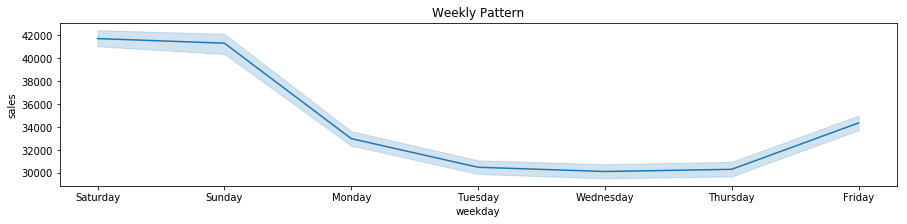

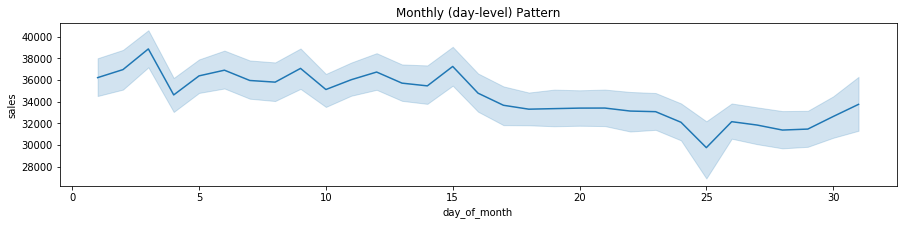

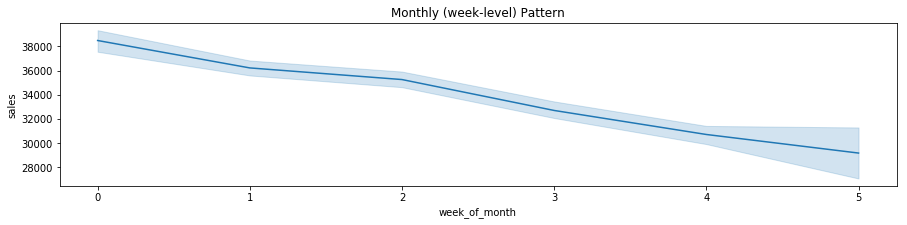

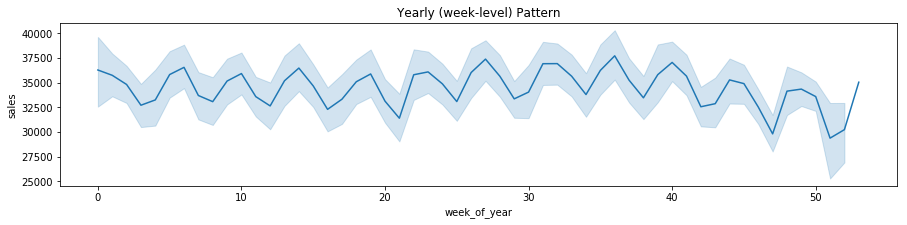

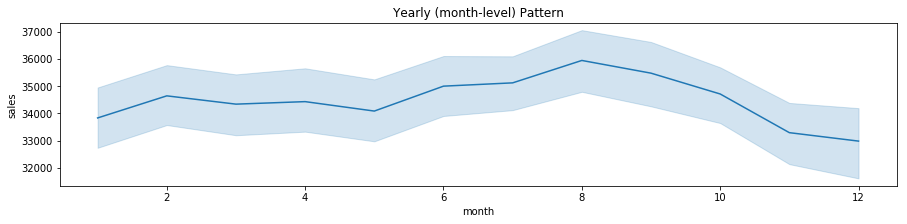

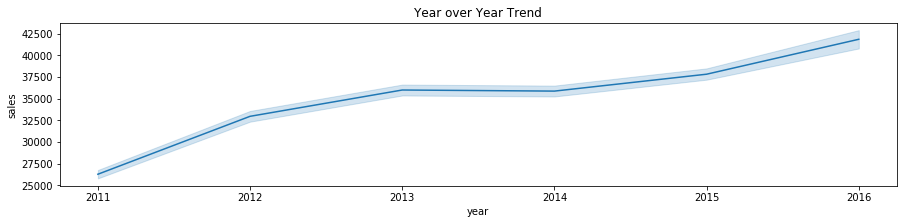

In [9]:
plt.figure(figsize=(15, 3))
plt.title('Weekly Pattern')
sns.lineplot(data=df_aggregated, x='weekday', y='sales')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Monthly (day-level) Pattern')
sns.lineplot(data=df_aggregated, x='day_of_month', y='sales')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Monthly (week-level) Pattern')
sns.lineplot(data=df_aggregated, x='week_of_month', y='sales')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Yearly (week-level) Pattern')
sns.lineplot(data=df_aggregated, x='week_of_year', y='sales')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Yearly (month-level) Pattern')
sns.lineplot(data=df_aggregated, x='month', y='sales')
plt.show()

plt.figure(figsize=(15, 3))
plt.title('Year over Year Trend')
sns.lineplot(data=df_aggregated, x='year', y='sales')
plt.show()

# Forecast at the Department-Store Aggregation Level

In [10]:
df_aggregated_dept_store = create_aggregated_sales(
    df_train,
    ['d', 'store_id', 'dept_id'],
    agg_dict
)

df_aggregated_dept_store['id'] = df_aggregated_dept_store['store_id'] + '_' + df_aggregated_dept_store['dept_id']

In [11]:
df_dept_store_train = pd.merge(
    df_aggregated_dept_store.pivot(index='date', columns='id', values='sales'),
    df2[['date', 'wday']],
    left_index=True,
    right_on='date'
).set_index('date')

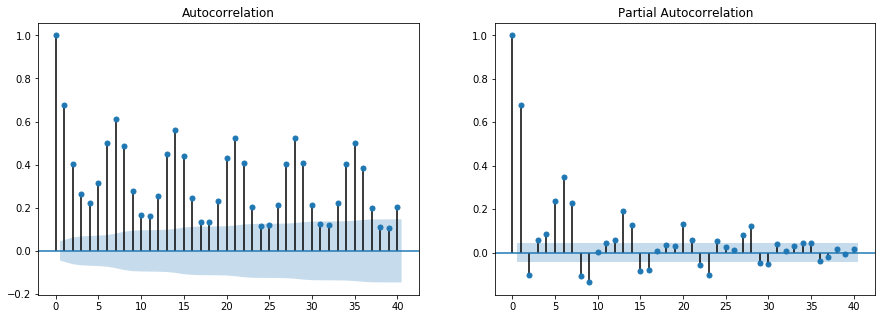

In [12]:
sample_data = df_dept_store_train.iloc[:-28, 0].values

# Autocorrelation Graphs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig = sm.graphics.tsa.plot_acf(sample_data, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(sample_data, lags=40, ax=axes[1])

In [13]:
def OHE_exog(x):
    # encode day of week as a tuple of boolean integers
    encoded_value = np.array(
        [x == 1, x == 2, x == 3, x == 4, x == 5, x == 6]
    ).astype(int).T

    return encoded_value

exog = OHE_exog(df_dept_store_train.iloc[:, -1].values)

# Estimate model
model = sm.tsa.statespace.SARIMAX(
    sample_data,
    exog=exog[: -28],
    trend='ct',
    order=(1, 1, 1)
)

res = model.fit(disp=False)

# Prediction
predict = res.get_prediction(28)
pred_ci = predict.conf_int()
forecast = res.predict(28)

# Plot Results

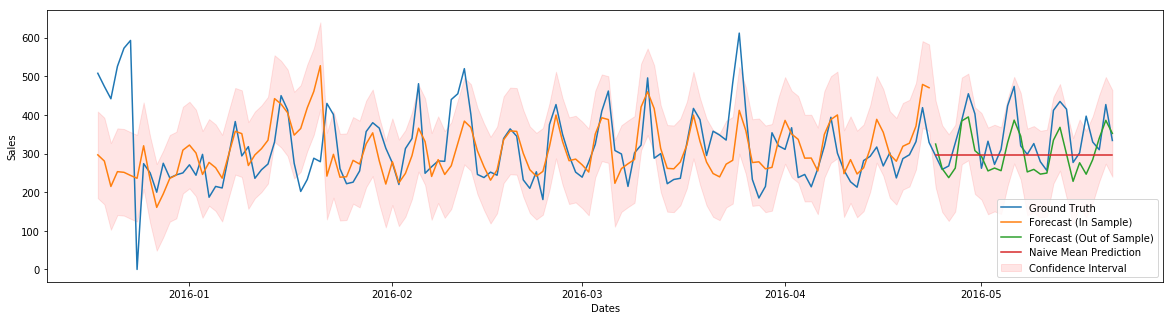

In [14]:
# Index and date housekeeping
n = 128
horizon = 28
start_id = n + horizon
end_date = df_dept_store_train.index.values.astype('M8[D]')[-1]
start_date = end_date - np.timedelta64(start_id, 'D')
dates = np.arange(start_date, end_date)

ground_truth = df_dept_store_train.iloc[-start_id:, 0].values
naive_prediction = sample_data.mean() * np.ones(horizon)

# plot forecasts
plt.figure(figsize=(20, 5))
plt.plot(dates, ground_truth, label='Ground Truth')
plt.plot(dates[: -horizon], forecast[-start_id: -horizon], label='Forecast (In Sample)')
plt.plot(dates[-horizon:], forecast[-horizon:], label='Forecast (Out of Sample)')
plt.plot(dates[-horizon:], naive_prediction, label='Naive Mean Prediction')
plt.fill_between(
    dates,
    pred_ci[-start_id::, 0],
    pred_ci[-start_id::, 1],
    color='r',
    alpha=0.1,
    label='Confidence Interval'
)
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [15]:
naive_error = np.sqrt(mean_squared_error(naive_prediction, ground_truth[-horizon:]))
sarima_error = np.sqrt(mean_squared_error(forecast[-horizon:], ground_truth[-horizon:]))

print(f"RMSE for Naive Model: {naive_error}")
print(f"RMSE for SARIMAX Model: {sarima_error}")

RMSE for Naive Model: 79.78102426312051
RMSE for SARIMAX Model: 62.222293778210556


# Parallel Estimation with Dask

Click on the link to the local client to view parallel processing steps

In [16]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:65406 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.06 GB


In [17]:
def forecast(sample, horizon=28):
    model = sm.tsa.statespace.SARIMAX(
        sample_data,
        exog=exog[:-horizon],
        trend='ct',
        order=(1, 1, 1)
    )

    res = model.fit(disp=False)
    return res.predict(horizon)[-horizon:]

In [18]:
forecast_ids = df_dept_store_train.columns
output_forecasts = []

for i in forecast_ids:
    forecasted_series = dask.delayed(forecast)(df_dept_store_train[i].values[:-horizon])
    output_forecasts.append(forecasted_series)

result = np.array(dask.delayed(output_forecasts).compute())
prediction_dates = df_dept_store_train.index.values[-horizon:]

df_predicted = pd.DataFrame(result.T, columns=forecast_ids, index=prediction_dates)